In [196]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
# import hdbscan
plt.rcParams.update({'font.size': 8})

**Function for reading in melt lakes from .h5 files generated by preliminary lake detection algorithm**

In [197]:
def convert_time_to_string(dt):
    epoch = dt + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d, %H:%M:%S")

def read_melt_lake_h5(fn):
    
    lakedict = {}
    with h5py.File(fn, 'r') as f:

        # metadata
        for key in f['properties'].keys(): 
            lakedict[key] = f['properties'][key][()]
            if f['properties'][key].dtype == object:
                lakedict[key] = lakedict[key].decode('utf-8')
                

        # photon data
        photon_data_dict = {}
        for key in f['photon_data'].keys():
            photon_data_dict[key] = f['photon_data'][key][()]
        lakedict['photon_data'] = pd.DataFrame(photon_data_dict)

        # mframe data
        mframe_data_dict = {}
        for key in f['mframe_data'].keys():
            mframe_data_dict[key] = f['mframe_data'][key][()]
        lakedict['mframe_data'] = pd.DataFrame(mframe_data_dict).set_index('mframe')    

        # second returns data
        det_2nds_dict = {}
        for key in f['detection_2nd_returns'].keys():
            det_2nds_dict[key] = f['detection_2nd_returns'][key][()]
        lakedict['detection_2nd_returns'] = det_2nds_dict

        # quality assessment data
        qual_dict = {}
        for key in f['detection_quality_info'].keys():
            qual_dict[key] = f['detection_quality_info'][key][()]
        lakedict['detection_quality_info'] = qual_dict
        
        # re-nest the lake extent segments
        def re_nest_extent(x): return [[x[i], x[i+1]] for i in np.arange(0,len(x),2)]
        lakedict['surface_extent_detection'] = re_nest_extent(lakedict['surface_extent_detection'])
        lakedict['lat_surface_extent_detection'] = re_nest_extent(lakedict['lat_surface_extent_detection'])
        
        lakedict['date_time'] = convert_time_to_string(lakedict['mframe_data']['dt'].mean())
        
        return lakedict

class dictobj:
    def __init__(self, in_dict:dict):
        assert isinstance(in_dict, dict)
        for key, val in in_dict.items():
            setattr(self, key, val)
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=0.0, min_depth=0.0, print_mframe_info=True):

        if len(self.detection_2nd_returns['h'])>0:
            lake_minh = np.min(self.detection_2nd_returns['h'])
        else: return
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+0.5*lake_max_depth))
        buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        buffer_top = (lake_maxh - lake_minh_plot) * 0.5
        lake_maxh_plot = lake_maxh + buffer_top
        ylms = (lake_minh_plot, lake_maxh_plot)
        xlms = (0.0, self.mframe_data.xatc_max.max())

        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            # plot the ATL03 photon data
            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                               edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
            p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                                 vmin=0, vmax=1, label='ATL03 photons')

            # plot surface elevation
            for xtent in self.surface_extent_detection:
                ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
            p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')

            # plot the second returns from detection
            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
            p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            # visualize which segments initially passed
            for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
                mf = self.mframe_data.iloc[i]
                if passing:
                    xy = (mf.xatc_min, ylms[0])
                    width = mf.xatc_max - mf.xatc_min
                    height = ylms[1] - ylms[0]
                    rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                    p_passed = ax.add_patch(rct)
                p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')

            # add a legend
            hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
            ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)

            # add the colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
                cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)

            # add labels and description in title
            txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
            txt += '%s Melt Season' % self.melt_season
            fig.suptitle(txt, y=0.95, fontsize=14)

            txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
            txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
            txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
            txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
            txt += 'granule ID: %s' % self.granule_id
            ax.set_title(txt, fontsize=8)

            ax.set_ylabel('elevation above geoid [m]',fontsize=8)
            ax.tick_params(axis='x', which='major', labelsize=7)
            ax.tick_params(axis='y', which='major', labelsize=6)
            # set limits
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # add latitude
            #_________________________________________________________
            lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
            lat = np.array(lx.lat)
            xatc = np.array(lx.xatc)
            def forward(x):
                return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
            def inverse(l):
                return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
            secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
            secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False) # show actual readable latitude values

            # rename x ticks
            xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(xticklabs)

            # add mframe info text
            if print_mframe_info:
                txt  = 'mframe:\n' % (mf.name%1000)
                txt += 'photons:\n' % mf.n_phot
                txt += 'peak:\n'
                txt += 'flat:\n'
                txt += 'SNR surf all:\n'
                txt += 'SNR surf above:\n'
                txt += 'SNR up:\n'
                txt += 'SNR low:\n'
                txt += '2nds:\n'
                txt += '2nds strength:\n'
                txt += '2nds number:\n'
                txt += '2nds spread:\n'
                txt += '2nds align:\n'
                txt += '2nds quality:\n'
                txt += 'pass:'
                # trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(-0.005, 0.98, txt, transform=ax.transAxes, fontsize=4, ha='right', va='top', bbox=bbox)
                for i,loc in enumerate(self.mframe_data['xatc']):
                    mf = self.mframe_data.iloc[i]
                    txt  = '%i\n' % (mf.name%1000)
                    txt += '%i\n' % mf.n_phot
                    txt += '%.2f\n' % mf.peak
                    txt += '%s\n' % ('Yes.' if mf.is_flat else 'No.')
                    txt += '%i\n' % np.round(mf.snr_surf)
                    txt += '%i\n' % np.round(mf.snr_allabove)
                    txt += '%i\n' % np.round(mf.snr_upper)
                    txt += '%i\n' % np.round(mf.snr_lower)
                    txt += '%i%%\n' % np.round(mf.ratio_2nd_returns*100)
                    txt += '%.2f\n' % mf.quality_secondreturns
                    txt += '%.2f\n' % mf.length_penalty
                    txt += '%.2f\n' % mf.range_penalty
                    txt += '%.2f\n' % mf.alignment_penalty
                    txt += '%.2f\n' % mf.quality_summary
                    txt += '%s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                    trans = ax.get_xaxis_transform()
                    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                    ax.text(loc, 0.98, txt, transform=trans, fontsize=4,ha='center', va='top', bbox=bbox)

            # add detection quality description
            txt  = 'LAKE QUALITY: %6.4f'%self.detection_quality
            txt += '\n---------------------------\n'
            txt += '2nd returns: %6.4f\n' % self.detection_quality_info['strength_2nd_returns']
            txt += 'alignment: %6.4f\n' % self.detection_quality_info['qual_alignment']
            txt += 'depth: %6.4f\n' % self.detection_quality_info['lake_depth']
            txt += 'length: %6.4f\n' % self.detection_quality_info['lake_length']
            txt += 'depth range: %6.4f' % self.detection_quality_info['h_range_2nd_returns']
            bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
            ax.text(0.99, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom',fontsize=6, weight='bold', bbox=bbox)

            fig.patch.set_facecolor('white')
            fig.tight_layout()
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # plt.close(fig)

            return fig

**Get a list of all the lakes to use**

In [198]:
searchfor = 'lake_'
searchdir = 'WAIS_region_comps/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]

searchfor = 'lake_'
searchdir = 'WAIS_2018-22-meltregions/'
filelist += [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f) & ('george' not in f)]

filelist.sort()
print('There are %i files.' % len(filelist))

There are 2940 files.


**Define parameters and functions for saturated pulse classification**

In [199]:
saturation_threshold = 1.0

cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']
peak_target_elevs = [0.0, -0.56, -0.93, -1.49, -1.85, -2.44, -4.28]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'target': peak_target_elevs, 'width': widths_pk, 'color': cols_pk, 'ls': lsty_pk})

##########################################################################################
def get_saturation_and_elevation(hvals, num_channels, dead_time):
    speed_of_light = 299792458 #m/s
    hvals = np.flip(np.sort(np.array(hvals).flatten()))
    if len(hvals) < num_channels:
        return pd.Series({'elev_saturation': np.nan, 'ratio_saturation': 0.0})
    else:
        diffs = np.abs(hvals[num_channels-1:] - hvals[:-num_channels+1])
        diff_threshold_saturated = dead_time * speed_of_light / 2.0
        diff_means_saturated = diffs <= diff_threshold_saturated
        if np.sum(diff_means_saturated) > 1:
            first_saturated_idx = next(i for i,val in enumerate(diffs) if val <= diff_threshold_saturated*1.0)
            first_saturated_elev = hvals[first_saturated_idx+num_channels-1]
            hvals = hvals[hvals > (first_saturated_elev - diff_threshold_saturated/2)]
            diffs = np.abs(hvals[num_channels-1:] - hvals[:-num_channels+1])
        start_saturated = np.argmin(diffs)
        end_saturated = start_saturated+num_channels
        hvals_saturated = hvals[start_saturated:end_saturated]
        elev_saturated = np.mean(hvals_saturated)
        # ratio_saturated = diff_threshold_saturated / (np.max(hvals_saturated)-np.min(hvals_saturated))
        ratio_saturated = diff_threshold_saturated / (4.0*np.std(hvals_saturated))
        
        return pd.Series({'elev_saturation': elev_saturated, 'ratio_saturation': ratio_saturated})
    
def to_hhmmss(secs): 
    h = np.floor(secs/(60*60))
    secs = secs-h*60*60
    m = np.floor(secs/60)
    s = secs - m*60
    return '%02i:%02i:%02i' % (h,m,s)

**Read in all the lakes and calculate saturation to figure out which lakes are good examples**

(this takes ~30mins, only run once) 

In [209]:
df_list = []
perc_sat_list = []
max_sat_list = []
n_lakes = 0
min_sat_vals_for_max = 100

# params for FPB determination
sat_threshold = 1.0
buffer = 0.4
bin_height_fine = 0.01
smoothing_histogram = 0.1

start = time.time()
# filelist = filelist[:20]
for i,filename in enumerate(filelist[:10]):
    
    lk = read_melt_lake_h5(filename)
    df = lk['photon_data']
    surf_elev = lk['surface_elevation']
    beam_strength = lk['beam_strength']
    deadtime = lk['dead_time']
    n_channels = 4 if beam_strength == 'weak' else 16
    df['pulseid'] = 1000*df.mframe.astype(np.uint64)+df.ph_id_pulse.astype(np.uint64)
    df['ph_index'] = df.index
    df = df.set_index('pulseid')
    thegroup = df.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
    kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
    saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
    df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
    df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
    df_join = df.join(df_grouped[['ratio_saturation', 'elev_saturation', 'is_saturated']], on='pulseid', how='left')
    
    dfns = df_join[df_join.ratio_saturation<sat_threshold] # not saturated
    dfns = dfns[(dfns.h > surf_elev-buffer) & (dfns.h < surf_elev+buffer)]
    if len(dfns > 100):
        bins = np.arange(start=surf_elev-buffer, stop=surf_elev+buffer, step=bin_height_fine)
        hist_mid = bins[:-1] + 0.5 * bin_height_fine
        hist = np.histogram(dfns.h, bins=bins)
        window_size = int(smoothing_histogram/bin_height_fine)
        hist_vals = hist[0] / np.max(hist[0])
        hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
        peak_loc = hist_mid[np.argmax(hist_vals_smoothed)]
    else:
        peak_loc = np.nan

    df_join['peak_loc_nonsaturated'] = peak_loc
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
    df_join['beam_strength'] = beam_strength
    df_join['beam_number'] = lk['beam_number']
    df_join['dead_time'] = lk['dead_time']
    df_join['gtx'] = lk['gtx']
    df_join['lake_nr'] = i
    
    perc_sat_list.append(np.sum(df_grouped.is_saturated) / len(df_grouped))
    
    saturation_list = np.sort(df_grouped.ratio_saturation[~np.isnan(df_grouped.ratio_saturation)])
    if len(saturation_list) >= min_sat_vals_for_max:
        max_sat_list.append(np.median(saturation_list[-min_sat_vals_for_max:]))
    
    df_list.append(df_join)
    
    elapsed = time.time() - start
    remaining = elapsed / (i+1) * (len(filelist)-i-1)
    print('reading in lake files: %4i / %4i   (elapsed: %s, remaining %s)' %\
          (i+1, len(filelist), to_hhmmss(elapsed), to_hhmmss(remaining)), end='\r')
    
dfs_all = pd.concat(df_list)
del df_list
print('\n---> done!')
# dfs_all.to_pickle('dfs_all.pkl')

reading in lake files:   10 / 2940   (elapsed: 00:00:04, remaining 00:23:00)
---> done!


In [200]:
dfs_all = pd.read_pickle('dfs_all.pkl')

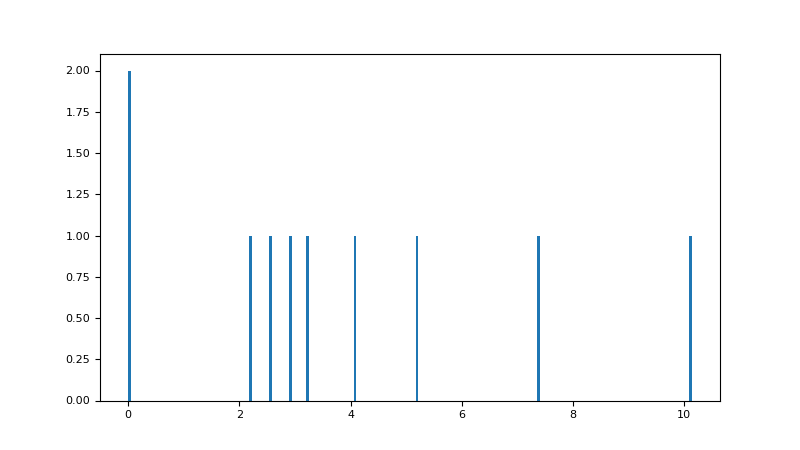

In [210]:
maxsats = dfs_all.groupby('lake_nr')['ratio_saturation'].apply(lambda x: np.percentile(x, 98))
#n = 30
#maxsats = dfs_all.groupby('lake_nr')['ratio_saturation'].apply(lambda x: np.median(np.array(x)[np.argsort(x)[-n:]]) if n<=len(x) else np.nan)
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.hist(maxsats, bins=200);

In [193]:
plt.close('all')

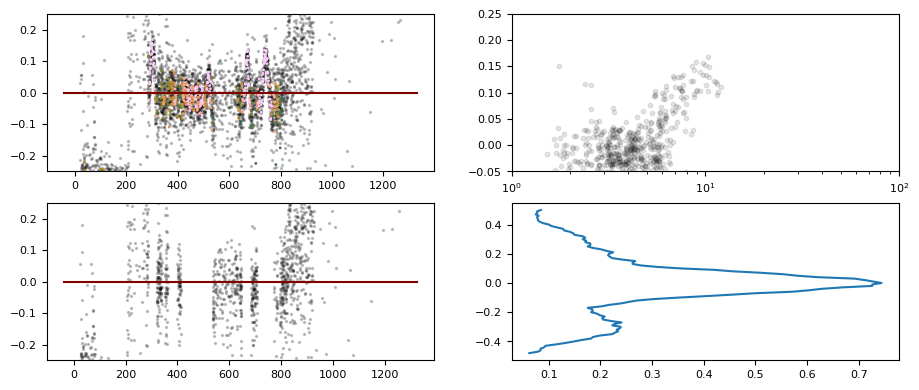

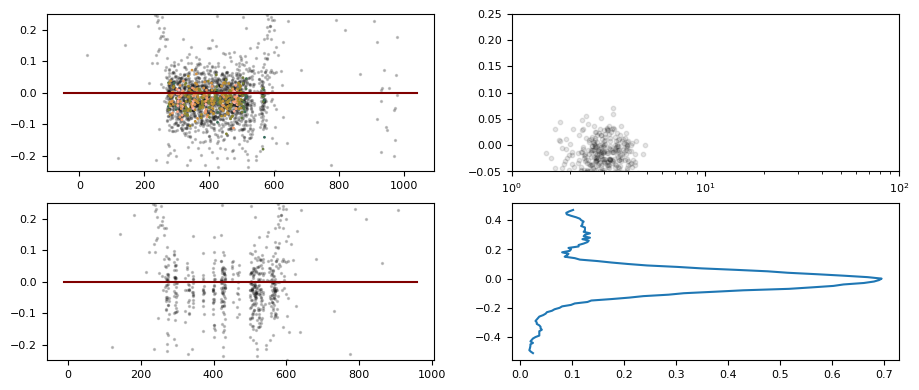

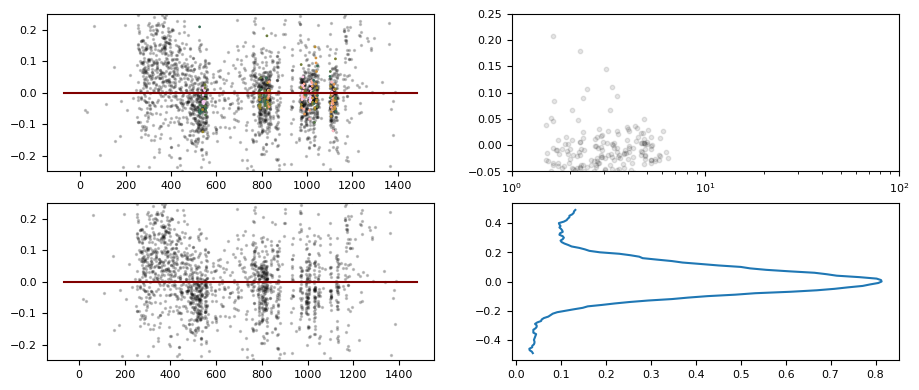

(0.0, 2.0)

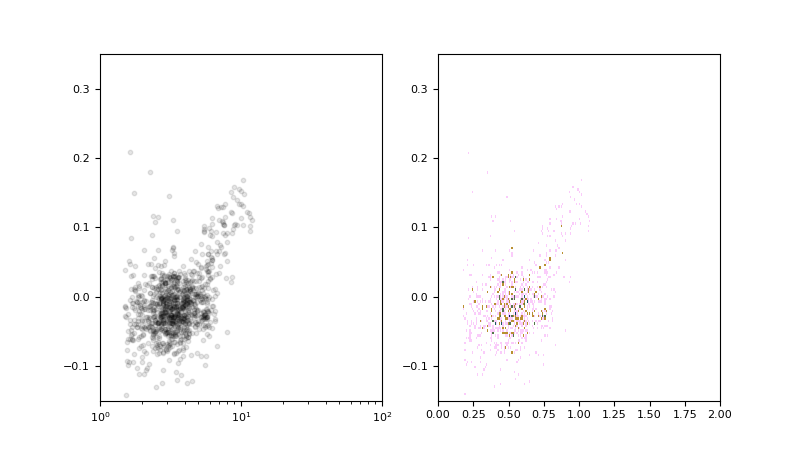

In [211]:
maxsats.sort_values(ascending=False, inplace=True)
idxlist = list(maxsats[(maxsats > 5) & (maxsats < 20)].index)
buff = 1
plot_this = True
sat_list, elev_list = [], []
yl = [-0.15, 0.35]
xl = [1, 100]
sat_threshold = 1.5
buffer = 0.5
bin_height_fine = 0.01
smoothing_histogram = 0.1
plt.close('all')

i=0
n=10
for idx in idxlist[i:i+n]:
    df = dfs_all[dfs_all.lake_nr == idx]
    surf_elev = df.peak_loc_nonsaturated.iloc[0]
    df = df[(df.h>(surf_elev-5)) & (df.h<(surf_elev+buff))]
    dfp = df.groupby('pulseid')[['xatc', 'elev_saturation', 'ratio_saturation']].mean()
    dfp['sat_smooth'] = dfp.ratio_saturation.rolling(window=11, center=True).mean()
    df = df.join(dfp['sat_smooth'], how='left')
    dfp = dfp[dfp.sat_smooth > sat_threshold]
    
    dfns = df[df.sat_smooth < 2.5]
    bins = np.arange(start=surf_elev-buffer, stop=surf_elev+buffer, step=bin_height_fine)
    hist_mid = bins[:-1] + 0.5 * bin_height_fine
    hist = np.histogram(dfns.h, bins=bins)
    window_size = int(smoothing_histogram/bin_height_fine)
    hist_vals = hist[0] / np.max(hist[0])
    hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
    peak_loc = hist_mid[np.argmax(hist_vals_smoothed)]
    surf_elev = peak_loc

    

    if plot_this:
        fig, axs = plt.subplots(figsize=[11, 4.5], dpi=100, ncols=2, nrows=2)
        axs = axs.flatten()
        ax = axs[0]
        ax.scatter(df.xatc, df.h-surf_elev, s=2, c='k', alpha=0.2)
        ax.scatter(dfp.xatc, dfp.elev_saturation-surf_elev, s=1, c=dfp.sat_smooth, cmap=cmc.batlow, vmin=0, vmax=5)
        ax.plot(ax.get_xlim(), [0]*2, color=(0.5, 0, 0))
        ax.set_ylim((-0.25,0.25))

        ax = axs[1]
        ax.scatter(dfp.sat_smooth, dfp.elev_saturation-surf_elev, s=10, c='k', alpha=0.1)
        ax.set_ylim((-0.05, 0.25))
        ax.set_xlim((1,100))
        ax.set_xscale('log')

        ax = axs[2]
        ax.scatter(dfns.xatc, dfns.h-surf_elev, s=2, c='k', alpha=0.2)
        ax.plot(ax.get_xlim(), [0]*2, color=(0.5, 0, 0))
        ax.set_ylim((-0.25, 0.25))

        ax = axs[3]
        ax.plot(hist_vals_smoothed, hist_mid-surf_elev)

        display(fig)
        plt.close(fig)

    sat_list += list(dfp.sat_smooth)
    elev_list += list(dfp.elev_saturation-surf_elev)

dffpb = pd.DataFrame({'sat': sat_list, 'elev': elev_list})
select = (dffpb.elev > yl[0]) & (dffpb.elev < yl[1]) & (dffpb.sat > xl[0]) & (dffpb.sat < xl[1])
dffpb = dffpb[select] 

fig, (ax,ax2) = plt.subplots(figsize=[8, 4.5], dpi=100, ncols=2)
ax.scatter(dffpb.sat, dffpb.elev, s=10, c='k', alpha=0.1)
ax.set_ylim(yl)
ax.set_xlim(xl)
ax.set_xscale('log')

ax2.hist2d(np.log10(dffpb.sat), dffpb.elev, bins=100, cmap=cmc.batlow_r, norm=matplotlib.colors.LogNorm());
ax2.set_ylim(yl)
ax2.set_xlim((0,2))


In [203]:
dfs_all

,geoid,h,lat,lon,mframe,ph_id_pulse,snr,xatc,ph_index,ratio_saturation,elev_saturation,is_saturated,peak_loc_nonsaturated,h_relative_to_saturated_peak,beam_strength,beam_number,dead_time,gtx,lake_nr
pulseid,,,,,,,,,,,,,,,,,,,
3961163203001,-37.993243,222.345874,-85.443689,-153.758829,3961163203,1,0.000000,0.000000,0,0.002963,147.758741,False,116.84925,74.587133,strong,5,2.972500e-09,gt3l,0
3961163203001,-37.993244,218.679737,-85.443689,-153.758827,3961163203,1,0.000000,0.011290,1,0.002963,147.758741,False,116.84925,70.920996,strong,5,2.972500e-09,gt3l,0
3961163203001,-37.993246,205.138937,-85.443688,-153.758818,3961163203,1,0.000000,0.053213,2,0.002963,147.758741,False,116.84925,57.380197,strong,5,2.972500e-09,gt3l,0
3961163203001,-37.993253,170.710690,-85.443686,-153.758797,3961163203,1,0.000000,0.160051,3,0.002963,147.758741,False,116.84925,22.951949,strong,5,2.972500e-09,gt3l,0
3961163203001,-37.993254,159.481299,-85.443686,-153.758790,3961163203,1,0.040107,0.194729,4,0.002963,147.758741,False,116.84925,11.722558,strong,5,2.972500e-09,gt3l,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256221274197,41.020911,1940.948694,66.169196,-47.316766,256221274,197,0.736218,1560.044415,2232,0.000000,NaN,False,1941.90159,NaN,weak,6,3.067500e-09,gt3r,2939
256221274198,41.020888,2044.961778,66.169203,-47.316787,256221274,198,0.000000,1560.988606,2233,0.000000,NaN,False,1941.90159,NaN,weak,6,3.067500e-09,gt3r,2939
256221274199,41.020873,2021.026735,66.169209,-47.316784,256221274,199,0.053608,1561.638042,2234,0.000000,NaN,False,1941.90159,NaN,weak,6,3.067500e-09,gt3r,2939


3.1622776601683795

In [93]:
axs

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

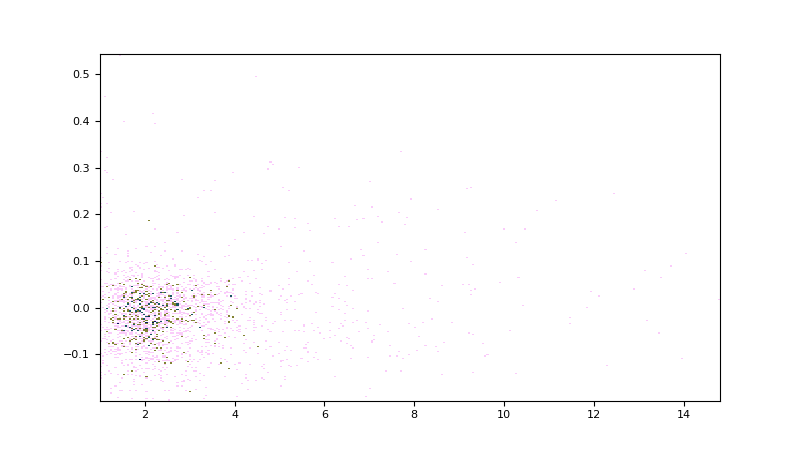

In [212]:
dfp = dfs_all.groupby('pulseid').first()
dfp = dfp[dfp.ratio_saturation > 1.0]
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)

x = np.array(dfp.ratio_saturation)
speed_of_light = 299792458
y = np.array((dfp.elev_saturation-dfp.peak_loc_nonsaturated)/(0.5*speed_of_light*dfp.dead_time))
p = pd.DataFrame({'x': x, 'y': y})
p = p[(p.x>1.0) & (p.x<15) & (p.y>-0.2) & (p.y<0.8)]
ax.hist2d(p.x, p.y, bins=300, cmap=cmc.batlow_r, norm=matplotlib.colors.LogNorm());

#ax.scatter(x, y, c=z, s=1, alpha=0.2, cmap=cmc.batlow)
# ax.set_ylim((-0.05, 0.25))
# ax.set_xlim((1.0, 8))

**Select the beam of interest, can put 'all' to keep all lakes**

In [6]:
beam_select = 'all'
if type(beam_select) == int:
    dfs = dfs_all[dfs_all.beam_number == beam_select]
    thisstrength = 'strong' if beam_select%2==1 else 'weak'
    beam_select_str = '#%i, %s' % (beam_select, thisstrength)
elif 'gt' in beam_select:
    dfs = dfs_all[dfs_all.gtx == beam_select]
elif beam_select == 'all':
    dfs = dfs_all
else:
    dfs = dfs_all[dfs_all.beam_strength == beam_select]
n_lakes = len(np.unique(dfs.lake_nr))

**Find the most saturated lakes for good test cases**

In [7]:
select_beam = -1
qual_thresh = 0.01
sort_by = 'percent_saturated'
# sort_by = 'max_ratio_saturated'

perc_sat = dfs_all.groupby('lake_nr')['is_saturated'].mean()
beamnr = dfs_all.groupby('lake_nr')['beam_number'].first()
beamstr = dfs_all.groupby('lake_nr')['beam_strength'].first()
gtx_lake = dfs_all.groupby('lake_nr')['beam_strength'].first()
df_perc_sat = pd.DataFrame({'percent_saturated': perc_sat, 'max_ratio_saturated': max_sat_list, 
                            'gtx': gtx_lake, 'beam_number': beamnr, 'beam_strength': beamstr, 'file': filelist})
groupbeams = df_perc_sat.groupby('beam_number')
summarydf = pd.DataFrame([groupbeams['beam_strength'].first(),
              groupbeams['percent_saturated'].mean(),
              groupbeams['max_ratio_saturated'].apply(np.percentile,**{'q': 95})])

if select_beam > 0: df_perc_sat = df_perc_sat[df_perc_sat.beam_nr==select_beam]
df_perc_sat['qual'] = [1-int(f[f.find('lake_')+5:f.find('lake_')+10])/1e4 for f in df_perc_sat.file]
df_perc_sat.sort_values(by='percent_saturated', inplace=True, ascending=False)
df_perc_sat_thresh = df_perc_sat[df_perc_sat.qual >= qual_thresh].copy()
for i in range(30):
    row = df_perc_sat_thresh.iloc[i]
    print('# %i : %.2f%% saturated, max ratio saturated: %.1f, beam %i (%s)'%\
          (i, row.percent_saturated, row.max_ratio_saturated, row.beam_number, row.beam_strength))
    print('fn = \'%s\'' % row.file)
    
summarydf

NameError: name 'max_sat_list' is not defined

In [ ]:
# for i in range(30):
#     row = df_perc_sat_thresh.iloc[i]
#     print('# %i : %.2f%% saturated, max ratio saturated: %.1f, beam %i (%s)'%\
#           (i, row.percent_saturated, row.max_ratio_saturated, row.beam_number, row.beam_strength))
#     print('fn = \'%s\'' % row.file)
#     lk = read_melt_lake_h5(row.file)
#     lake = dictobj(lk)
#     lake.plot_detected(print_mframe_info=False)
#     print('\n\n')

**Go on to test removal of pulses on only some good test cases**

In [ ]:
from scipy.special import erf

strong


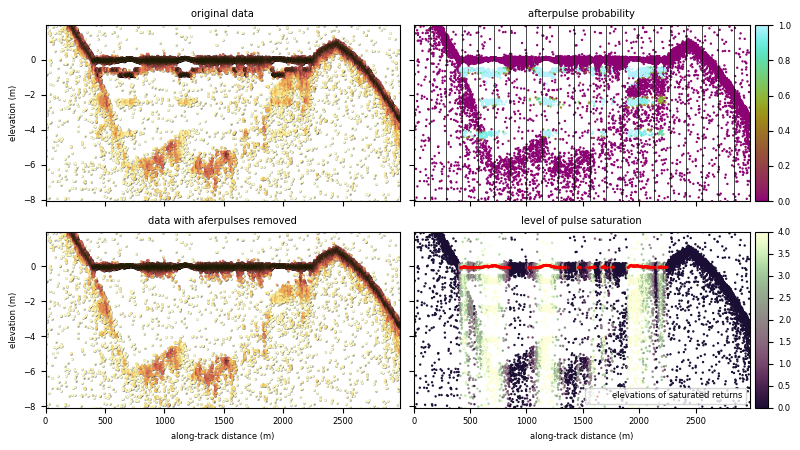

In [213]:
fn = 'WAIS_region_comps/lake_07092_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07938_AIS_2018-19_amery_ATL03_20190116064007_02870212_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07770_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_05643_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_2018-22-meltregions/lake_06558_AIS_2019-20_waismeltregions_wilkins_ATL03_20200118094903_03460610_005_01_gt3r.h5'
# fn = 'WAIS_region_comps/lake_07950_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07314_AIS_2018-19_amery_ATL03_20190123173555_04010210_005_01_gt3l.h5'
# fn = 'WAIS_2018-22-meltregions/lake_09978_AIS_2021-22_waismeltregions_larsen_ATL03_20220116110420_03841412_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_09177_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5'
# fn = 'WAIS_region_comps/lake_09875_GrIS_2019_west_greenland_ATL03_20190617064249_12220303_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_09326_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_08353_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5'
# fn = 'zzz_random_files/lake_05857_GrIS_2022_jakobshavn_small_ATL03_20220714010847_03381603_006_02_gt2r.h5'
# fn = 'zzz_random_files/lake_01785_GrIS_2022_jakobshavn_small_ATL03_20220714010847_03381603_006_02_gt1r.h5'

lk = read_melt_lake_h5(fn)
lake = dictobj(lk)
df_photon = lk['photon_data']
surf_elev = lk['surface_elevation']
beam_strength = lk['beam_strength']
deadtime = lk['dead_time']
n_channels = 4 if beam_strength == 'weak' else 16
df_mframe = lk['mframe_data']

peak_target_elevs = [-0.56, -0.93, -1.47, -1.85, -2.44, -4.25]
widths_pk = [0.3, 0.225, 0.225, 0.225, 0.35, 0.3]
diff_pk_tols = [0.1, 0.1, 0.1, 0.1, 0.2, 0.2]
rem_thresh_strong = [0.6, 2.7, 5.0, 30.0, 1.0, 1.0]
rem_thresh_weak = [0.6, 4.0, 5.0, 15.0, 1.0, 1.0]
cols_pk = ['#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
range_full_removal = 0.05


df_photon['prob_afterpulse'] = 0.0
df_photon['sat_ratio'] = 0.0
df_photon['sat_ratio_smooth'] = 0.0
# df_photon['fpb'] = 0.0
df_photon['sat_elev'] = np.nan
df_photon['pulseid'] = 1000*df_photon.mframe.astype(np.uint64)+df_photon.ph_id_pulse.astype(np.uint64)

for mframe in df_mframe.index:
    selector_mframe = df_photon.mframe==mframe
    df = df_photon[selector_mframe].copy()
    df['ph_index'] = df.index
    df = df.set_index('pulseid')
    thegroup = df.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
    kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
    saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
    df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
    speed_of_light = 299792458 #m/s
    diff_threshold_saturated = deadtime * speed_of_light / 2.0
    df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
    ratio_saturation_smooth = df_grouped.ratio_saturation.rolling(5, center=True, min_periods=1).mean()
    df_grouped['ratio_saturation_smooth'] = np.max(np.vstack((ratio_saturation_smooth, df_grouped.ratio_saturation)), axis=0)
    varlist = ['ratio_saturation', 'ratio_saturation_smooth', 'elev_saturation', 'is_saturated']
    df_join = df.join(df_grouped[varlist], on='pulseid', how='left')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
    df_join['beam_strength'] = beam_strength
    df_join['beam_number'] = lk['beam_number']
    df_join['gtx'] = lk['gtx']
    df_join['h_rel_to_sat'] = df_join.h - df_join.elev_saturation
    
    if np.sum(df_join.is_saturated) > 200:
        bin_h = 0.01
        smooth_h_top = 0.08
        smooth_h_middle = 0.15
        smooth_h_bottom = 0.3
        switch1 = -1.2
        switch2 = -2.1
        bins = np.arange(-5, 0.5+bin_h, bin_h)
        mids = bins[:-1] + 0.5*bin_h
        smooth_top = int(np.round(smooth_h_top/bin_h))
        smooth_middle = int(np.round(smooth_h_middle/bin_h))
        smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
        # histweights = df_join.ratio_saturation_smooth*df_join.snr
        histweights = df_join.ratio_saturation_smooth
        hist_h = np.histogram(df_join.h_rel_to_sat, bins=bins, weights=histweights)
        hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
        hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
        hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
        seg1 = hist_h_smooth_bottom[mids<=switch2]
        seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
        seg3 = hist_h_smooth_top[mids>switch1]
        hist_h_smooth = np.concatenate((seg1, seg2, seg3))
        hist_h_plot_smooth = np.log(hist_h_smooth+1)
        hist_h_plot_smooth /= hist_h_plot_smooth.max()

        hist_peakfind = hist_h_plot_smooth[mids<=-0.35]
        mids_peakfind = mids[mids<=-0.35]
        peaks, props = find_peaks(hist_peakfind, distance=int(np.round(0.1/bin_h)), prominence=0.01)
        props['idx'] = peaks
        props['elev'] = np.round(mids_peakfind[peaks],2)
        props['height'] = hist_peakfind[peaks]
        df_sat = pd.DataFrame(props)
        df_sat.reset_index(drop=True, inplace=True)
        df_sat.sort_values(by='prominences', ascending=False, ignore_index=True, inplace=True)
        df_sat = df_sat.iloc[:7]
        df_sat.sort_values(by='elev', ascending=False, ignore_index=True, inplace=True)

        for i, pk in enumerate(peak_target_elevs):
            diffs = np.abs(df_sat.elev - pk)
            mindiff = np.min(diffs)
            if mindiff < diff_pk_tols[i]:
                thispk = df_sat.iloc[np.argmin(diffs)].elev
                sel = (df_join.h_rel_to_sat > (thispk-widths_pk[i])) & (df_join.h_rel_to_sat < (thispk+widths_pk[i]))
                dfpk = df_join[sel].copy()
                thisthresh = rem_thresh_strong[i] if beam_strength == 'strong' else rem_thresh_weak[i]
                thresh_factor = (dfpk.ratio_saturation_smooth >= thisthresh) * 0.6
                # if i > 3: 
                #     thresh_factor *= 0.5
                prob = np.clip(thresh_factor * dfpk.ratio_saturation_smooth * (1-np.abs(1/widths_pk[i]*(dfpk.h_rel_to_sat-thispk))**2)**3, 0, 1)
                prob *=  np.clip(widths_pk[i]/(widths_pk[i]-range_full_removal) - mindiff/(widths_pk[i]-range_full_removal), 0, 1)
                dfpk['prob_rem'] = prob
                df_join.loc[sel, 'prob_afterpulse'] += dfpk.prob_rem
                
        df_photon.loc[selector_mframe, 'prob_afterpulse'] = np.array(df_join.prob_afterpulse)
        df_photon.loc[selector_mframe, 'sat_ratio'] = np.array(df_join.ratio_saturation)
        df_photon.loc[selector_mframe, 'sat_ratio_smooth'] = np.array(df_join.ratio_saturation_smooth)
        df_photon.loc[selector_mframe, 'sat_elev'] = np.array(df_join.elev_saturation)
        
        
plt.close('all')
plt.rc('font', size=6)
print(beam_strength)
fig, axs = plt.subplots(figsize=[8, 4.5], dpi=100, nrows=2, ncols=2, sharex=True, sharey=True)

lake_minh = np.min(lake.detection_2nd_returns['h'])
lake_max_depth = np.abs(lake.main_peak - np.min(lake.detection_2nd_returns['h']))
lake_segment_length = np.abs(np.max(lake.detection_2nd_returns['xatc']) - np.min(lake.detection_2nd_returns['xatc']))
lake_maxh = lake.main_peak
buffer_bottom = 1.0
lake_minh_plot = lake_minh - buffer_bottom
buffer_top = 2.0
lake_maxh_plot = lake_maxh + buffer_top
ylms = np.array((lake_minh_plot, lake_maxh_plot)) - surf_elev
xlms = (0.0, lake.mframe_data.xatc_max.max())

df_photon['snr_corr'] = np.clip(df_photon.snr - df_photon.prob_afterpulse, 0, 1)
ax = axs[0,0]
ax.scatter(df_photon.xatc, df_photon.h-surf_elev, s=1, c='k', alpha=0.3)
scatt = ax.scatter(df_photon.xatc, df_photon.h-surf_elev, s=0.5, alpha=1, c=df_photon.snr, cmap=cmc.lajolla, vmin=0, vmax=1)
ax.set_title('original data')

ax = axs[1,0]
df_photon['remove_afterpulse'] = df_photon.prob_afterpulse > np.random.uniform(0,1,len(df_photon))
dfp = df_photon[~df_photon.remove_afterpulse]
ax.scatter(dfp.xatc, dfp.h-surf_elev, s=1, c='k', alpha=0.3)
scatt = ax.scatter(dfp.xatc, dfp.h-surf_elev, s=0.5, alpha=1, c=dfp.snr_corr, cmap=cmc.lajolla, vmin=0, vmax=1)
ax.set_title('data with aferpulses removed')

ax = axs[0,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h-surf_elev, s=0.5, alpha=1, c=df_photon.prob_afterpulse, cmap=cmc.hawaii, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
ax.set_title('afterpulse probability')
ymin, ymax = ax.get_ylim()
mframe_bounds_xatc = list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]
for xmframe in mframe_bounds_xatc:
    ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

ax = axs[1,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h-surf_elev, s=0.5, alpha=1, c=df_photon.sat_ratio_smooth, cmap=cmc.tokyo, vmin=0, vmax=4)
dfpulse = df_photon.groupby('pulseid').median()
dfpulse = dfpulse[dfpulse.sat_ratio > 1.0]
# corr_h = pd.Series(dfpulse.sat_elev-surf_elev-(erf((dfpulse.sat_ratio - 5) / 2.5) + 1) * 0.1125).rolling(5,center=True,min_periods=1).mean()
#corr_h = pd.Series(dfpulse.sat_elev-surf_elev-dfpulse.fpb).rolling(5,center=True,min_periods=1).mean()
satelevs = ax.scatter(dfpulse.xatc, dfpulse.sat_elev-surf_elev, s=0.5, c='r', alpha=0.3, label='elevations of saturated returns')
# ax.plot(dfpulse.xatc, corr_h, c=(0.5, 0, 0))
# satelevs_corr = ax.scatter(dfpulse.xatc, dfpulse.sat_elev - dfpulse.fpb - surf_elev, s=0.5, c='b', label='FPB correction applied')
# ax.scatter(dfpulse.xatc, (dfpulse.sat_ratio-1)*0.03, s=0.5, c='g')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
ax.set_title('level of pulse saturation')
ax.legend(handles=[satelevs], loc='lower right', fontsize=6, numpoints=4)

for ax in axs.flatten():
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    
axs[0,0].set_ylabel('elevation (m)')
axs[1,0].set_ylabel('elevation (m)')
axs[1,0].set_xlabel('along-track distance (m)')
axs[1,1].set_xlabel('along-track distance (m)') 

fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_all.jpg', dpi=600)


# fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
# ax.scatter(df_photon.xatc, df_photon.h-surf_elev, s=1, c='k', alpha=1)
# ax.set_title('original data')
# ax.set_ylabel('elevation (m)')
# ax.set_xlabel('along-track distance (m)')
# ax.set_xlim(xlms)
# ax.set_ylim(ylms)
# fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp1.jpg', dpi=600)

# fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
# ax.scatter(dfp.xatc, dfp.h-surf_elev, s=1, c='k', alpha=1)
# ax.set_title('data with aferpulses removed')
# ax.set_ylabel('elevation (m)')
# ax.set_xlabel('along-track distance (m)')
# ax.set_xlim(xlms)
# ax.set_ylim(ylms)
# fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp2.jpg', dpi=600)

1233.3239488738934


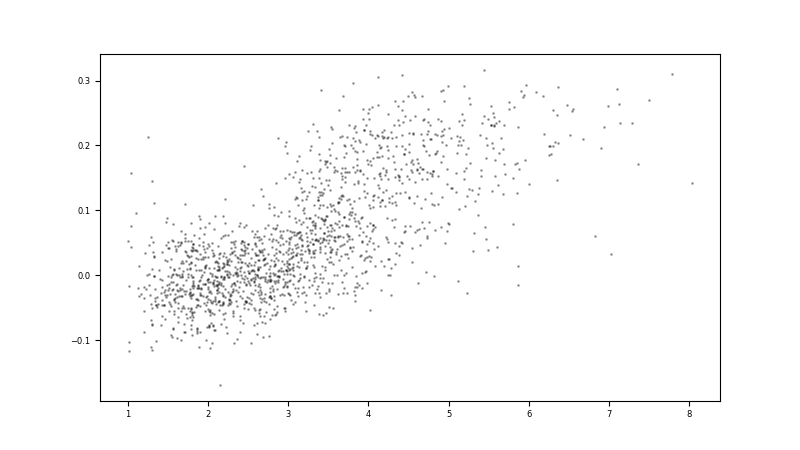

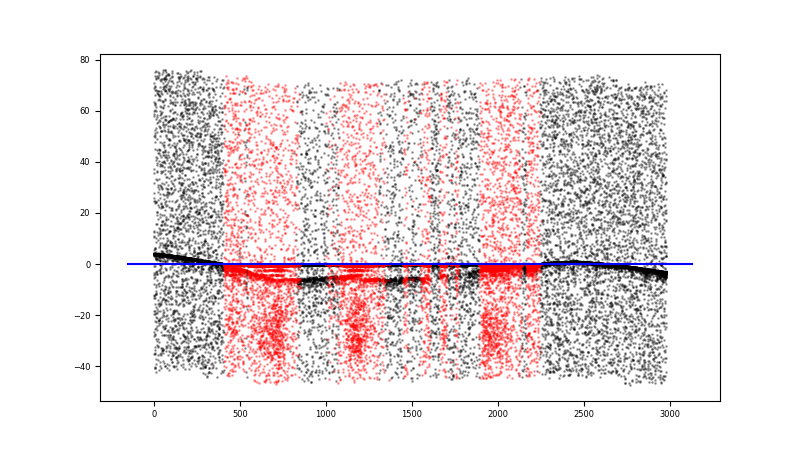

In [84]:
sat_threshold = 1.0
buffer = 0.4
bin_height_fine = 0.01
smoothing_histogram = 0.1
df_join = df_photon.copy()
dfns = df_join[df_join.sat_ratio<sat_threshold]
dfis = df_join[df_join.sat_ratio>=sat_threshold]

bins = np.arange(start=surf_elev-buffer, stop=surf_elev+buffer, step=bin_height_fine)
hist_mid = bins[:-1] + 0.5 * bin_height_fine
hist = np.histogram(dfns.h, bins=bins)
window_size = int(smoothing_histogram/bin_height_fine)
hist_vals = hist[0] / np.max(hist[0])
hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
peak_loc = hist_mid[np.argmax(hist_vals_smoothed)]
dfp.sat_elev-peak_loc

print(peak_loc)
# fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
# ax.plot(hist_vals_smoothed, hist_mid)

dfp = dfis.groupby('pulseid').first()
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfp.sat_ratio, (dfp.sat_elev-peak_loc)/(0.5*speed_of_light*deadtime), s=1, c='k', alpha=0.3)

fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfns.xatc, dfns.h-peak_loc, s=1, c='k', alpha=0.3)
ax.scatter(dfis.xatc, dfis.h-peak_loc, s=1, c='r', alpha=0.3)
ax.plot(ax.get_xlim(), [0]*2, 'b-')



In [28]:
dfp

,geoid,h,lat,lon,mframe,ph_id_pulse,snr,xatc,prob_afterpulse,sat_ratio,sat_ratio_smooth,sat_elev,snr_corr,remove_afterpulse
pulseid,,,,,,,,,,,,,,
1573424352001,35.830620,1198.249336,67.231980,-48.993150,1573424352,1,0.051203,0.000000,0.0,0.0,0.0,NaN,0.051203,False
1573424352002,35.830612,1206.575027,67.231986,-48.993152,1573424352,2,0.000000,0.736401,0.0,0.0,0.0,NaN,0.000000,False
1573424352003,35.830605,1229.703697,67.231993,-48.993155,1573424352,3,0.000000,1.514099,0.0,0.0,0.0,NaN,0.000000,False
1573424352004,35.830599,1205.305266,67.231999,-48.993157,1573424352,4,0.063804,2.158963,0.0,0.0,0.0,NaN,0.063804,False
1573424352005,35.830591,1214.939184,67.232005,-48.993159,1573424352,5,0.063340,2.898954,0.0,0.0,0.0,NaN,0.063340,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573424372196,35.804868,1227.832950,67.258501,-49.001065,1573424372,196,0.122704,2977.464051,0.0,0.0,0.0,NaN,0.122704,False
1573424372197,35.804863,1201.178291,67.258506,-49.001066,1573424372,197,0.000000,2978.097110,0.0,0.0,0.0,NaN,0.000000,False
1573424372198,35.804858,1191.227979,67.258513,-49.001068,1573424372,198,0.021090,2978.777020,0.0,0.0,0.0,NaN,0.021090,False


In [ ]:
speed_of_light = 299792458 #m/s
diff_threshold_saturated = deadtime * speed_of_light / 2.0
# fpb_corr = 0.5 * thresh_saturated * (1.0 - (1.0/df_join.ratio_saturation[df_join.ratio_saturation>1.0]))
ratio_saturated = 2
0.5 * diff_threshold_saturated * (1.0 - (1.0/ratio_saturated)) if ratio_saturated>1 else 0.0
np.max(df_photon.sat_ratio)

In [ ]:
from scipy.special import erf
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfpulse.sat_ratio_smooth,dfpulse.sat_elev-surf_elev, alpha=0.05)
x = np.linspace(1,9)
y = (erf((x - 5) / 2) + 1) * 0.1 - 0.05
ax.plot(x,y)

# Get number of photons for each afterpulse as a function of saturation ratio

In [ ]:
beam_select = 'all'
if type(beam_select) == int:
    dfs = dfs_all[dfs_all.beam_number == beam_select]
    thisstrength = 'strong' if beam_select%2==1 else 'weak'
    beam_select_str = '#%i, %s' % (beam_select, thisstrength)
elif 'gt' in beam_select:
    dfs = dfs_all[dfs_all.gtx == beam_select]
elif beam_select == 'all':
    dfs = dfs_all
else:
    dfs = dfs_all[dfs_all.beam_strength == beam_select]
n_lakes = len(np.unique(dfs.lake_nr))

In [ ]:
lakelist = ['WAIS_region_comps/lake_07092_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5',
            'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5',
            'WAIS_region_comps/lake_07938_AIS_2018-19_amery_ATL03_20190116064007_02870212_005_01_gt2l.h5',
            'WAIS_region_comps/lake_07770_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2l.h5',
            'WAIS_region_comps/lake_05643_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5',
            'WAIS_2018-22-meltregions/lake_06558_AIS_2019-20_waismeltregions_wilkins_ATL03_20200118094903_03460610_005_01_gt3r.h5',
            'WAIS_region_comps/lake_07950_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5',
            'WAIS_region_comps/lake_07314_AIS_2018-19_amery_ATL03_20190123173555_04010210_005_01_gt3l.h5',
            'WAIS_2018-22-meltregions/lake_09978_AIS_2021-22_waismeltregions_larsen_ATL03_20220116110420_03841412_005_01_gt2r.h5',
            'WAIS_region_comps/lake_09177_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5']

lakelist = filelist
peak_target_elevs = [0.0, -0.55, -0.92, -1.49, -1.84, -2.43, -4.24]
peak_descriptions = ['surface_return', 'deadtime1', 'deadtime2', 'deadtime3', 'deadtime4', 'atlas_reflection1', 'atlas_reflection2']
widths_pk = [0.3, 0.225, 0.225, 0.225, 0.225, 0.3, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
df_lists = {k: [] for k in peak_descriptions}

In [ ]:
start = time.time()
for ilake, fn in enumerate(lakelist): 
    lk = read_melt_lake_h5(fn)
    lake = dictobj(lk)
    df = lk['photon_data']
    surf_elev = lk['surface_elevation']
    beam_strength = lk['beam_strength']
    deadtime = lk['dead_time']
    n_channels = 4 if beam_strength == 'weak' else 16

    df['pulseid'] = 1000*df.mframe.astype(np.uint64)+df.ph_id_pulse.astype(np.uint64)
    df['ph_index'] = df.index
    df = df.set_index('pulseid')
    thegroup = df.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
    kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
    saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
    df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
    df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
    df_join = df.join(df_grouped[['ratio_saturation', 'elev_saturation', 'is_saturated']], on='pulseid', how='left')
    ratio_saturation_smooth = df_join.ratio_saturation.rolling(5, center=True, min_periods=1).mean()
    df_join['ratio_saturation_smooth'] = np.max(np.vstack((ratio_saturation_smooth, df_join.ratio_saturation)), axis=0)
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
    df_join['beam_strength'] = beam_strength
    df_join['beam_number'] = lk['beam_number']
    df_join['gtx'] = lk['gtx']
    df_join['h_rel_to_sat'] = df_join.h - df_join.elev_saturation
    df_counts_tojoin = df_join[['ratio_saturation', 'ratio_saturation_smooth', 'beam_strength']].groupby('pulseid').first()

    for i, pk in enumerate(peak_target_elevs):
        thispk = peak_target_elevs[i]
        thiswidth = widths_pk[i]
        sel = (df_join.h_rel_to_sat > (thispk-thiswidth)) & (df_join.h_rel_to_sat < (thispk+thiswidth))
        dfpk = df_join[sel].copy()
        dfpk['weights'] = (1-np.abs(1/widths_pk[i]*(dfpk.h_rel_to_sat-thispk))**2)**3
        counts = dfpk['weights'].groupby('pulseid').count() / n_channels
        weighted_counts = dfpk['weights'].groupby('pulseid').sum() / n_channels
        df_counts = pd.DataFrame({'counts': counts, 'weighted_counts': weighted_counts})
        df_counts_joined = df_counts_tojoin.join(df_counts, on='pulseid', how='left')
        df_counts_joined.loc[np.isnan(df_counts_joined.counts), 'counts'] = 0.0
        df_counts_joined.loc[np.isnan(df_counts_joined.weighted_counts), 'weighted_counts'] = 0.0
        df_counts_joined = df_counts_joined[df_counts_joined.ratio_saturation >= 0.1]
        peak_description = peak_descriptions[i]
        df_lists[peak_description].append(df_counts_joined)
        
    elapsed = time.time() - start
    remaining = elapsed / (ilake+1) * (len(lakelist)-ilake-1)
    print('reading in lake files: %4i / %4i   (elapsed: %s, remaining %s)' %\
          (ilake+1, len(lakelist), to_hhmmss(elapsed), to_hhmmss(remaining)), end='\r')

for k,v in df_lists.items():
    df_lists[k] = pd.concat(v)
        

In [ ]:
# import pickle
# with open('df_lists.pickle', 'wb') as handle:
#     pickle.dump(df_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('df_lists.pickle', 'rb') as handle:
    df_lists = pickle.load(handle)

In [ ]:
plt.close('all')
dfsstrong, dfsweak = {}, {}
for k,v in df_lists.items():
    dfsstrong[k] = v[v.beam_strength=='strong'].copy()
for k,v in df_lists.items():
    dfsweak[k] = v[v.beam_strength=='weak'].copy()
lowess_dict_strong, lowess_dict_weak = {}, {}
    
from scipy.stats import binned_statistic
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
lowess_frac = 1./3
min_vals=10

plt.rcParams.update({'font.size': 5})
fig, axs = plt.subplots(figsize=[8, 4.5], dpi=110, nrows=2, ncols=4, sharex=True, sharey=True)

# min_vals = 10
for ip in range(len(df_lists)):

    ax = axs.flatten()[ip]
    item = list(df_lists.keys())[ip]
    
#     dfsweak[item]['ratio_saturation'] = dfsweak[item].ratio_saturation_smooth
#     dfsstrong[item]['ratio_saturation'] = dfsstrong[item].ratio_saturation_smooth

#     dfsweak[item]['weighted_counts'] = dfsweak[item].counts
#     dfsstrong[item]['weighted_counts'] = dfsstrong[item].counts

#     dfsweak[item] = dfsweak[item][dfsweak[item].counts > 0]
#     dfsstrong[item] = dfsstrong[item][dfsstrong[item].counts > 0]
    
    strong_counts_plot = dfsstrong[item].weighted_counts.copy()
    weak_counts_plot = dfsweak[item].weighted_counts.copy()
    strong_counts_plot = np.clip(strong_counts_plot, 1e-3, 1.0)
    weak_counts_plot = np.clip(weak_counts_plot, 1e-3, 1.0)
    ax.scatter(dfsstrong[item].ratio_saturation, strong_counts_plot, s=1, alpha=0.02, c='C0')
    ax.scatter(dfsweak[item].ratio_saturation, weak_counts_plot, s=1, alpha=0.02, c='C1')
    strongscatt = ax.scatter(0, 0, s=5, alpha=0.5, c='C0', label='strong photon counts')
    weakscatt = ax.scatter(0, 0, s=5, alpha=0.5, c='C1', label='weak photon counts')
    
    bins = np.concatenate((np.arange(0.9, 5, 0.1), np.arange(5,20,1), np.arange(20,300,10)))
    mids = bins[:-1]+np.diff(bins)
    line_weak = binned_statistic(dfsweak[item].ratio_saturation, dfsweak[item].weighted_counts, statistic='mean', bins=bins)
    nnzcountsweak = dfsweak[item][dfsweak[item].weighted_counts>0.0]
    line_weak_counts = binned_statistic(dfsweak[item].ratio_saturation, dfsweak[item].weighted_counts, statistic='count', bins=bins)
    weak_y = line_weak.statistic[line_weak_counts.statistic>=min_vals]
    weak_x = mids[line_weak_counts.statistic>=min_vals]
    line_strong = binned_statistic(dfsstrong[item].ratio_saturation, dfsstrong[item].weighted_counts, statistic='mean', bins=bins)
    nnzcountsstrong = dfsstrong[item][dfsstrong[item].weighted_counts>0.0]
    line_strong_counts = binned_statistic(nnzcountsstrong.ratio_saturation, nnzcountsstrong.weighted_counts, statistic='count', bins=bins)
    strong_y = line_strong.statistic[line_strong_counts.statistic>=min_vals]
    strong_x = mids[line_strong_counts.statistic>=min_vals]    
    strongbinned = ax.scatter(strong_x, strong_y, s=2, c='b', alpha=1, label='strong binned means')
    weakbinned = ax.scatter(weak_x, weak_y, s=2, c='r', alpha=1, label='weak binned means')

    fit_weak = lowess(weak_y, weak_x, frac=lowess_frac, it=0)
    lowess_dict_weak[item] = fit_weak
    fit_strong = lowess(strong_y, strong_x, frac=lowess_frac, it=0)
    lowess_dict_strong[item] = fit_strong
    strongplot, = ax.plot(fit_strong[:,0], fit_strong[:,1], c=(0,0,0.5), label='strong fit')
    weakplot, = ax.plot(fit_weak[:,0], fit_weak[:,1], c=(0.5,0,0), ls='-', label='weak fit')

    ax.set_title('%s (%g m +/- %g m)' % (item, peak_target_elevs[ip], widths_pk[ip]), color=cols_pk[ip], fontweight='bold')
    if ip in [0, 4]:
        ax.set_ylabel('# photons / # channels')
    if ip in [4, 5, 6, 7]:
        ax.set_xlabel('level of saturation')
    ax.set_xlim((1.0, 100))
    if ip == 0:
        ax.set_ylim((0.3, 1.05))
    else:
        ax.set_ylim((0.99e-3, 1.05))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    ax.grid(b=True, which='major', color='k', lw=0.3, linestyle='-', alpha=0.5)
    ax.grid(b=True, which='minor', color='k', lw=0.5, linestyle='--', alpha=0.2)
    
#     if ip == 0: 
#         leg = ax.legend(handles=hdls, ncol=2, loc='lower right', numpoints=4)
#         fig.suptitle('photon counts of surface return vs. sensor saturation level over %i melt lakes' % (len(lakelist)), fontsize=10)
#         fig.tight_layout()
#         plt.savefig('surface_photon_count_vs_saturation_level.jpg', dpi=600)
#     if ip == 1: 
#         leg = plt.figlegend(handles=hdls, ncol=2, loc='center', bbox_to_anchor=(0.52, 0.42), numpoints=4)

hdls = [strongscatt, weakscatt, strongbinned, weakbinned, strongplot, weakplot]
leg = plt.figlegend(handles=hdls, ncol=1, loc='center', bbox_to_anchor=(0.88, 0.3), numpoints=4, fontsize=6)  
fig.suptitle('photon counts of afterpulses vs. sensor saturation level over %i melt lakes' % (len(lakelist)), fontsize=10)
axs.flatten()[-1].axis('off')
fig.tight_layout()
plt.savefig('afterpulse_photon_count_vs_saturation_level_weighted_counts.jpg', dpi=600)

In [ ]:
plt.close('all')

test_correction_factor = 16

plt.rcParams.update({'font.size': 5})
fig, axs = plt.subplots(figsize=[8, 4.5], dpi=110, nrows=2, ncols=3, sharex=True, sharey=True)

def get_rem_prob(fit, correction_factor=1.0):
    x = fit[:,0]
    vals = fit[:,1]
    prob = np.clip(1.0-np.min(vals[x<2.5]/test_correction_factor/correction_factor)/vals, 0.0, 1.0)
    return prob

df_satcorr = pd.DataFrame({'saturation_level': xs})
# min_vals = 10
for ip in range(len(lowess_dict_strong)-1):
    
    ix = ip+1
    ax = axs.flatten()[ip]
    item = list(df_lists.keys())[ix]
    
    corr = 1.0
    if ip==0:
        corr = 3.0
    prob_strong = get_rem_prob(lowess_dict_strong[item], correction_factor = corr)
    prob_weak = get_rem_prob(lowess_dict_weak[item])
    
    pint_strong = np.interp(xs, lowess_dict_strong[item][:,0], prob_strong)
    pint_weak = np.interp(xs, lowess_dict_weak[item][:,0], prob_weak)
    
    df_satcorr[item+'_strong'] = pint_strong
    df_satcorr[item+'_weak'] = pint_weak
    
    strongplot, = ax.plot(xs, pint_strong, c=(0,0,0.5), label='strong beams')
    weakplot, = ax.plot(xs, pint_weak, c=(0.5,0,0), ls='-', label='weak beams')
    
    ax.set_title('%s (%g m +/- %g m)' % (item, peak_target_elevs[ip], widths_pk[ip]), color=cols_pk[ip], fontweight='bold')
    if ip in [0, 3]:
        ax.set_ylabel('photon removal probability')
    if ip in [3, 4, 5]:
        ax.set_xlabel('level of saturation')
    ax.set_xlim((1.0, 100))
    ax.set_ylim((-0.01,1.01))
    ax.set_xscale('log')
    ax.grid()
    ax.grid(b=True, which='major', color='k', lw=0.3, linestyle='-', alpha=0.5)
    ax.grid(b=True, which='minor', color='k', lw=0.5, linestyle='--', alpha=0.2)


hdls = [strongplot, weakplot]
leg = ax.legend(handles=hdls, ncol=1, loc='upper right', numpoints=4, fontsize=5)  
fig.suptitle('photon removal probabilities vs. pulse saturation level', fontsize=10)
fig.tight_layout()
plt.savefig('afterpulse_photon_removal_probabilities.jpg', dpi=600)

In [ ]:
peak_target_elevs = [0.0, -0.55, -0.92, -1.49, -1.84, -2.43, -4.24]
peak_descriptions = ['surface_return', 'deadtime1', 'deadtime2', 'deadtime3', 'deadtime4', 'atlas_reflection1', 'atlas_reflection2']
widths_pk = [0.3, 0.225, 0.225, 0.225, 0.225, 0.3, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
weight_func = 'weights = (1-np.abs(1/peak_width*(h_rel_to_sat-peak_elev))**2)**3'
afterpulse_removal_info = {'p_remove': df_satcorr, 
                           'peak_elevs': peak_target_elevs, 
                           'peak_widths': widths_pk, 
                           'peak_names': peak_descriptions,
                           'peak_colors': cols_pk,
                           'weight_func_str': weight_func
                          }
# with open('afterpulse_removal_info_20230525.pickle', 'wb') as handle:
#     pickle.dump(afterpulse_removal_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Remove afterpulses based on empirical functions

In [ ]:
lakelist = ['WAIS_region_comps/lake_07092_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5',
            'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5',
            'WAIS_region_comps/lake_07938_AIS_2018-19_amery_ATL03_20190116064007_02870212_005_01_gt2l.h5',
            'WAIS_region_comps/lake_07770_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2l.h5',
            'WAIS_region_comps/lake_05643_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5',
            'WAIS_2018-22-meltregions/lake_06558_AIS_2019-20_waismeltregions_wilkins_ATL03_20200118094903_03460610_005_01_gt3r.h5',
            'WAIS_region_comps/lake_07950_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5',
            'WAIS_region_comps/lake_07314_AIS_2018-19_amery_ATL03_20190123173555_04010210_005_01_gt3l.h5',
            'WAIS_2018-22-meltregions/lake_09978_AIS_2021-22_waismeltregions_larsen_ATL03_20220116110420_03841412_005_01_gt2r.h5',
            'WAIS_region_comps/lake_09177_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5']

fn = lakelist[0]
peak_target_elevs = [0.0, -0.55, -0.92, -1.49, -1.84, -2.43, -4.24]
peak_descriptions = ['surface_return', 'deadtime1', 'deadtime2', 'deadtime3', 'deadtime4', 'atlas_reflection1', 'atlas_reflection2']
widths_pk = [0.3, 0.225, 0.225, 0.225, 0.225, 0.3, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']

lk = read_melt_lake_h5(fn)
lake = dictobj(lk)
df_photon = lk['photon_data']
surf_elev = lk['surface_elevation']
beam_strength = lk['beam_strength']
deadtime = lk['dead_time']
n_channels = 4 if beam_strength == 'weak' else 16
df_mframe = lk['mframe_data']

df_photon['prob_afterpulse'] = 0.0
df_photon['sat_ratio'] = 0.0
df_photon['sat_ratio_smooth'] = 0.0
df_photon['sat_elev'] = np.nan

df_photon['pulseid'] = 1000*df_photon.mframe.astype(np.uint64)+df_photon.ph_id_pulse.astype(np.uint64)
df_photon['ph_index'] = df_photon.index
df_photon = df_photon.set_index('pulseid')
thegroup = df_photon.groupby('pulseid')
df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
df_join = df_photon.join(df_grouped[['ratio_saturation', 'elev_saturation', 'is_saturated']], on='pulseid', how='left')
ratio_saturation_smooth = df_join.ratio_saturation.rolling(5, center=True, min_periods=1).mean()
df_join['ratio_saturation_smooth'] = np.max(np.vstack((ratio_saturation_smooth, df_join.ratio_saturation)), axis=0)
df_join['is_saturated'] = df_join.ratio_saturation >= 1.0
df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
df_join['beam_strength'] = beam_strength
df_join['beam_number'] = lk['beam_number']
df_join['gtx'] = lk['gtx']
df_join['h_rel_to_sat'] = df_join.h - df_join.elev_saturation

for ilist, pk in enumerate(peak_target_elevs[1:]):
    i = ilist + 1
    peak_description = peak_descriptions[i]
    thispkelev = peak_target_elevs[i]
    thiswidth = widths_pk[i]
    sel = df_join.is_saturated & (df_join.h_rel_to_sat > (thispkelev-thiswidth)) & (df_join.h_rel_to_sat < (thispkelev+thiswidth))
    dfpk = df_join[sel].copy()
    dfpk['weights'] = (1-np.abs(1/thiswidth*(dfpk.h_rel_to_sat-thispkelev))**2)**3
    rem_probs_data = df_satcorr[peak_description + '_' + beam_strength]
    rem_probs = np.interp(dfpk.ratio_saturation, df_satcorr.saturation_level, rem_probs_data)
    dfpk['rem_probs'] = rem_probs * dfpk.weights
    df_join.loc[sel, 'prob_afterpulse'] += dfpk.rem_probs

#         df_photon.loc[selector_mframe, 'prob_afterpulse'] = np.array(df_join.prob_afterpulse)
#         df_photon.loc[selector_mframe, 'sat_ratio'] = np.array(df_join.ratio_saturation)
#         df_photon.loc[selector_mframe, 'sat_ratio_smooth'] = np.array(df_join.ratio_saturation_smooth)
#         df_photon.loc[selector_mframe, 'sat_elev'] = np.array(df_join.elev_saturation)
        
df_photon = df_join.copy()   

plt.close('all')
plt.rc('font', size=6)
fig, axs = plt.subplots(figsize=[8, 4.5], dpi=100, nrows=2, ncols=2, sharex=True, sharey=True)

lake_minh = np.min(lake.detection_2nd_returns['h'])
lake_max_depth = np.abs(lake.main_peak - np.min(lake.detection_2nd_returns['h']))
lake_segment_length = np.abs(np.max(lake.detection_2nd_returns['xatc']) - np.min(lake.detection_2nd_returns['xatc']))
lake_maxh = lake.main_peak
buffer_bottom = 1.0
lake_minh_plot = lake_minh - buffer_bottom
buffer_top = 2.0
lake_maxh_plot = lake_maxh + buffer_top
ylms = (lake_minh_plot, lake_maxh_plot)
xlms = (0.0, lake.mframe_data.xatc_max.max())

ax = axs[0,0]
# ax.scatter(df_photon.xatc, df_photon.h, s=0.5, c='k', alpha=0.3)
scatt = ax.scatter(df_photon.xatc, df_photon.h, s=0.5, alpha=1, c='k')
ax.set_title('original data')

ax = axs[1,0]
df_photon['remove_afterpulse'] = df_photon.prob_afterpulse > np.random.uniform(0,1,len(df_photon))
dfp = df_photon[~df_photon.remove_afterpulse]
# ax.scatter(dfp.xatc, dfp.h, s=0.5, c='k', alpha=0.3)
scatt = ax.scatter(dfp.xatc, dfp.h, s=0.5, alpha=1, c='k')
ax.set_title('data with aferpulses removed')

ax = axs[0,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h, s=0.5, alpha=1, c=df_photon.prob_afterpulse, cmap=cmc.hawaii, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
ax.set_title('afterpulse probability')
ymin, ymax = ax.get_ylim()
mframe_bounds_xatc = list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]
for xmframe in mframe_bounds_xatc:
    ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

ax = axs[1,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h, s=0.5, alpha=1, c=df_photon.ratio_saturation, cmap=cmc.tokyo, vmin=0, vmax=4)
dfpulse = df_photon.groupby('pulseid').first()
dfpulse = dfpulse[dfpulse.sat_ratio > 1.0]
satelevs = ax.scatter(dfpulse.xatc, dfpulse.elev_saturation, s=0.5, c='r', label='elevations of saturated returns')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
ax.set_title('level of pulse saturation')
ax.legend(handles=[satelevs], loc='lower right', fontsize=6, numpoints=4)

for ax in axs.flatten():
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    
axs[0,0].set_ylabel('elevation (m)')
axs[1,0].set_ylabel('elevation (m)')
axs[1,0].set_xlabel('along-track distance (m)')
axs[1,1].set_xlabel('along-track distance (m)') 

fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_all.jpg', dpi=600)


fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(df_photon.xatc, df_photon.h, s=1, c='k', alpha=1)
ax.set_title('original data')
ax.set_ylabel('elevation (m)')
ax.set_xlabel('along-track distance (m)')
ax.set_xlim(xlms)
ax.set_ylim(ylms)
fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp1.jpg', dpi=600)

fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfp.xatc, dfp.h, s=1, c='k', alpha=1)
ax.set_title('data with aferpulses removed')
ax.set_ylabel('elevation (m)')
ax.set_xlabel('along-track distance (m)')
ax.set_xlim(xlms)
ax.set_ylim(ylms)
fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp2.jpg', dpi=600)

In [ ]:
df_satcorr

In [ ]:
x = np.linspace(0,1)
y = (1-np.abs(1/0.5*(x-0.5))**2)**3
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
ip = 0
item = list(df_lists.keys())[ip]
x = dfsweak[item].saturation
y = dfsweak[item].weighted_counts
fit = lowess(y, x, frac=1./10)
ax.scatter(x,y,s=1,alpha=0.03)
ax.plot(fit[:,0], fit[:,1], 'b-')
ax.set_xscale('log')

In [ ]:
line_weak_counts

In [ ]:
fn = 'WAIS_region_comps/lake_07092_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07938_AIS_2018-19_amery_ATL03_20190116064007_02870212_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07770_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_05643_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_2018-22-meltregions/lake_06558_AIS_2019-20_waismeltregions_wilkins_ATL03_20200118094903_03460610_005_01_gt3r.h5'
# fn = 'WAIS_region_comps/lake_07950_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07314_AIS_2018-19_amery_ATL03_20190123173555_04010210_005_01_gt3l.h5'
# fn = 'WAIS_2018-22-meltregions/lake_09978_AIS_2021-22_waismeltregions_larsen_ATL03_20220116110420_03841412_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_09177_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5'
# fn = 'WAIS_region_comps/lake_09875_GrIS_2019_west_greenland_ATL03_20190617064249_12220303_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_09326_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_08353_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt1r.h5'

lk = read_melt_lake_h5(fn)
lake = dictobj(lk)
df_photon = lk['photon_data']
surf_elev = lk['surface_elevation']
beam_strength = lk['beam_strength']
deadtime = lk['dead_time']
n_channels = 4 if beam_strength == 'weak' else 16
df_mframe = lk['mframe_data']

peak_target_elevs = [0.0, -0.56, -0.93, -1.49, -1.85, -2.44, -4.28]
widths_pk = [0.3, 0.3, 0.3, 0.2, 0.2, 0.35, 0.3]
diff_pk_tols = [0.0, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15]
prob_factors = [0.0, 0.6, 0.6, 0.6, 0.6, 0.35, 0.35]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']

df_photon['prob_afterpulse'] = 0.0
df_photon['sat_ratio'] = 0.0
df_photon['sat_elev'] = np.nan
df_photon['pulseid'] = 1000*df_photon.mframe.astype(np.uint64)+df_photon.ph_id_pulse.astype(np.uint64)

df = df_photon.copy()
# df['pulseid'] = 1000*df.mframe.astype(np.uint64)+df.ph_id_pulse.astype(np.uint64)
df['ph_index'] = df.index
df = df.set_index('pulseid')
thegroup = df.groupby('pulseid')
df_grouped = thegroup[['xatc', 'lat', 'lon']].mean()
kwargs = {'num_channels': n_channels, 'dead_time': deadtime}
saturation_fraction_and_elevation = thegroup[['h']].apply(get_saturation_and_elevation, **kwargs)
df_grouped = pd.concat([df_grouped, saturation_fraction_and_elevation], axis=1)
df_grouped['is_saturated'] = df_grouped.ratio_saturation >= saturation_threshold
df_join = df.join(df_grouped[['ratio_saturation', 'elev_saturation', 'is_saturated']], on='pulseid', how='left')
df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.elev_saturation
df_join['beam_strength'] = beam_strength
df_join['beam_number'] = lk['beam_number']
df_join['gtx'] = lk['gtx']
df_join['h_rel_to_sat'] = df_join.h - df_join.elev_saturation
# df_join['lake_nr'] = i

if np.sum(df_join.is_saturated) > 200:

    bin_h = 0.01
    smooth_h_top = 0.05
    smooth_h_middle = 0.2
    smooth_h_bottom = 0.4
    switch1 = -1.2
    switch2 = -2.1
    bins = np.arange(-5, 0.5+bin_h, bin_h)
    mids = bins[:-1] + 0.5*bin_h
    smooth_top = int(np.round(smooth_h_top/bin_h))
    smooth_middle = int(np.round(smooth_h_middle/bin_h))
    smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
    hist_h = np.histogram(df_join.h_rel_to_sat, bins=bins, weights=df_join.ratio_saturation)
    hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
    hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
    hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
    seg1 = hist_h_smooth_bottom[mids<=switch2]
    seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
    seg3 = hist_h_smooth_top[mids>switch1]
    hist_h_smooth = np.concatenate((seg1, seg2, seg3))
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_plot_smooth = np.log(hist_h_smooth+1)
    hist_h_plot_smooth /= hist_h_plot_smooth.max()
    histplot = np.log(hist_h[0]+1)
    histplot /= np.max(histplot)

    hist_peakfind = hist_h_plot_smooth[mids<=-0.35]
    mids_peakfind = mids[mids<=-0.35]
    peaks, props = find_peaks(hist_peakfind, distance=int(np.round(0.2/bin_h)), prominence=0.01)
    props['idx'] = peaks
    props['elev'] = np.round(mids_peakfind[peaks],2)
    props['height'] = hist_peakfind[peaks]
    df_sat = pd.DataFrame(props)
    df_sat.reset_index(drop=True, inplace=True)
    df_sat.sort_values(by='prominences', ascending=False, ignore_index=True, inplace=True)
    df_sat = df_sat.iloc[:6]
    df_sat.sort_values(by='elev', ascending=False, ignore_index=True, inplace=True)

    # df_join['prob_afterpulse'] = 0.0
    for i, pk in enumerate(peak_target_elevs):
        diffs = np.abs(df_sat.elev - pk)
        if np.min(diffs) < diff_pk_tols[i]:
            thispk = df_sat.iloc[np.argmin(diffs)].elev
            sel = (df_join.h_rel_to_sat > (thispk-widths_pk[i])) & (df_join.h_rel_to_sat < (thispk+widths_pk[i]))
            dfpk = df_join[sel].copy()
            dfpk['prob_rem'] = prob_factors[i] * dfpk.ratio_saturation * (1-np.abs(1/widths_pk[i]*(dfpk.h_rel_to_sat-thispk))**2)**3
            #dfpk['remove'] = dfpk.prob_rem > np.random.uniform(0,1,len(dfpk))
            df_join.loc[sel, 'prob_afterpulse'] += dfpk.prob_rem
            #df_join.loc[sel, 'remove_afterpulse'] = dfpk.remove

    df_photon['prob_afterpulse'] = np.array(df_join.prob_afterpulse)
    df_photon['sat_ratio'] = np.array(df_join.ratio_saturation)
    df_photon['sat_elev'] = np.array(df_join.elev_saturation)

        
plt.close('all')
plt.rc('font', size=6)
fig, axs = plt.subplots(figsize=[8, 4.5], dpi=100, nrows=2, ncols=2, sharex=True, sharey=True)

lake_minh = np.min(lake.detection_2nd_returns['h'])
lake_max_depth = np.abs(lake.main_peak - np.min(lake.detection_2nd_returns['h']))
lake_segment_length = np.abs(np.max(lake.detection_2nd_returns['xatc']) - np.min(lake.detection_2nd_returns['xatc']))
lake_maxh = lake.main_peak
buffer_bottom = 1.0
lake_minh_plot = lake_minh - buffer_bottom
buffer_top = 2.0
lake_maxh_plot = lake_maxh + buffer_top
ylms = (lake_minh_plot, lake_maxh_plot)
xlms = (0.0, lake.mframe_data.xatc_max.max())

ax = axs[0,0]
ax.scatter(df_photon.xatc, df_photon.h, s=0.5, c='k', alpha=0.3)
ax.set_title('original data')

ax = axs[1,0]
# df_photon['remove_afterpulse'] = df_photon.prob_afterpulse > 0.5
df_photon['remove_afterpulse'] = df_photon.prob_afterpulse > np.random.uniform(0,1,len(df_photon))
dfp = df_photon[~df_photon.remove_afterpulse]
ax.scatter(dfp.xatc, dfp.h, s=0.5, c='k', alpha=0.3)
ax.set_title('data with aferpulses removed')

ax = axs[0,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h, s=0.5, alpha=1, c=df_photon.prob_afterpulse, cmap=cmc.hawaii, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 8
# cbar.ax.set_ylabel('afterpulse probability', rotation=270, fontsize=6)
ax.set_title('afterpulse probability')
ymin, ymax = ax.get_ylim()
mframe_bounds_xatc = list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]
for xmframe in mframe_bounds_xatc:
    ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

ax = axs[1,1]
scatt = ax.scatter(df_photon.xatc, df_photon.h, s=0.5, alpha=1, c=df_photon.sat_ratio, cmap=cmc.tokyo, vmin=0, vmax=4)
dfpulse = df_photon.groupby('pulseid').median()
dfpulse = dfpulse[dfpulse.sat_ratio > 1]
satelevs = ax.scatter(dfpulse.xatc, dfpulse.sat_elev, s=0.5, c='r', label='elevations of saturated returns')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 8
# cbar.ax.set_ylabel('level of saturation', rotation=270, fontsize=6)
ax.set_title('level of pulse saturation')
ax.legend(handles=[satelevs], loc='lower right', fontsize=6, numpoints=4)

for ax in axs.flatten():
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    
axs[0,0].set_ylabel('elevation (m)')
axs[1,0].set_ylabel('elevation (m)')
axs[1,0].set_xlabel('along-track distance (m)')
axs[1,1].set_xlabel('along-track distance (m)') 

fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_all.jpg', dpi=600)


fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(df_photon.xatc, df_photon.h, s=1, c='k', alpha=1)
ax.set_title('original data')
ax.set_ylabel('elevation (m)')
ax.set_xlabel('along-track distance (m)')
ax.set_xlim(xlms)
ax.set_ylim(ylms)
fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp1.jpg', dpi=600)

fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfp.xatc, dfp.h, s=1, c='k', alpha=1)
ax.set_title('data with aferpulses removed')
ax.set_ylabel('elevation (m)')
ax.set_xlabel('along-track distance (m)')
ax.set_xlim(xlms)
ax.set_ylim(ylms)
fig.tight_layout()
# plt.savefig('sat-figs/'+fn[fn.find('/')+1:-3]+'_comp2.jpg', dpi=600)

In [ ]:
fig, (ax,ax2) = plt.subplots(figsize=[9, 5], dpi=100, ncols=2)
phscatt = ax.scatter(df_join.xatc, df_join.h_rel_to_sat, s=0.5, alpha=1, c=df_join.ratio_saturation, cmap=cmc.batlow_r, vmin=0.5, vmax=5)
dfpulse = df_join.groupby('pulseid').median()
# dfpulse = dfpulse[dfpulse.is_saturated].copy()
for i, pk in enumerate(peak_target_elevs):
    ax.plot([df_join.xatc.min(), df_join.xatc.max()], [pk]*2, color=cols_pk[i], lw=1)
    rect = Rectangle((df_join.xatc.min(), pk-widths_pk[i]), df_join.xatc.max()-df_join.xatc.min(), 2*widths_pk[i], 
                     edgecolor = 'none', facecolor = cols_pk[i], alpha=0.2)
    ax.add_patch(rect)
# ax.scatter(dfpulse.xatc, dfpulse.elev_saturation, s=1, alpha=1, c='red')
ax.set_xlabel('along_track distance (m)')
ax.set_ylabel('elevation (m)')

# add the colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(phscatt, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.set_ylabel('saturation level', rotation=270, fontsize=8)
ax.set_ylim((-5,0.5))
ax.set_xlim((df_join.xatc.min(), df_join.xatc.max()))
    
for i, pk in enumerate(peak_target_elevs):
    ax2.plot([0,1000], [pk]*2, color=cols_pk[i], lw=1)
    rect = Rectangle((0, pk-widths_pk[i]), 1000, 2*widths_pk[i], edgecolor = 'none', facecolor = cols_pk[i], alpha=0.2)
    ax2.add_patch(rect)

bin_h = 0.01
smooth_h_top = 0.05
smooth_h_middle = 0.2
smooth_h_bottom = 0.4
switch1 = -1.2
switch2 = -2.1
bins = np.arange(-5, 0.5+bin_h, bin_h)
mids = bins[:-1] + 0.5*bin_h
smooth_top = int(np.round(smooth_h_top/bin_h))
smooth_middle = int(np.round(smooth_h_middle/bin_h))
smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
hist_h = np.histogram(df_join.h_rel_to_sat, bins=bins, weights=df_join.ratio_saturation)
hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
seg1 = hist_h_smooth_bottom[mids<=switch2]
seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
seg3 = hist_h_smooth_top[mids>switch1]
hist_h_smooth = np.concatenate((seg1, seg2, seg3))
hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
hist_h_plot_smooth = np.log(hist_h_smooth+1)
hist_h_plot_smooth /= hist_h_plot_smooth.max()
histplot = np.log(hist_h[0]+1)
histplot /= np.max(histplot)
ax2.scatter(histplot, mids, s=2, c='k', alpha=0.3)
ax2.plot(hist_h_plot_smooth, mids, c='k')
ax2.set_ylim((-5, 0.5))
ax2.set_xlim((0, np.max(histplot)))

hist_peakfind = hist_h_plot_smooth[mids<=-0.35]
mids_peakfind = mids[mids<=-0.35]
peaks, props = find_peaks(hist_peakfind, distance=int(np.round(0.2/bin_h)), prominence=0.01)
props['idx'] = peaks
props['elev'] = np.round(mids_peakfind[peaks],2)
props['height'] = hist_peakfind[peaks]
df_sat = pd.DataFrame(props)
df_sat.reset_index(drop=True, inplace=True)
df_sat.sort_values(by='prominences', ascending=False, ignore_index=True, inplace=True)
df_sat = df_sat.iloc[:6]
df_sat.sort_values(by='elev', ascending=False, ignore_index=True, inplace=True)

df_join['prob_afterpulse'] = 0.0
df_join['remove_afterpulse'] = False
for i, pk in enumerate(peak_target_elevs):
    diffs = np.abs(df_sat.elev - pk)
    if np.min(diffs) < diff_pk_tols[i]:
        thispk = df_sat.iloc[np.argmin(diffs)].elev
        print(thispk)
        sel = (df_join.h_rel_to_sat > (thispk-widths_pk[i])) & (df_join.h_rel_to_sat < (thispk+widths_pk[i]))
        dfpk = df_join[sel].copy()
        dfpk['prob_rem'] = 0.5 * dfpk.ratio_saturation * (1-np.abs(1/widths_pk[i]*(dfpk.h_rel_to_sat-thispk))**2)**3
        dfpk['remove'] = dfpk.prob_rem > np.random.uniform(0,1,len(dfpk))
        df_join.loc[sel, 'prob_afterpulse'] = dfpk.prob_rem
        df_join.loc[sel, 'remove_afterpulse'] = dfpk.remove


fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
dfp = df_join[~df_join.remove_afterpulse]
scatt = ax.scatter(dfp.xatc, dfp.h_rel_to_sat, s=0.5, alpha=1, c=dfp.prob_afterpulse, cmap=cmc.batlow, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.set_ylabel('saturation level', rotation=270, fontsize=8)

In [ ]:
df_sat

## this is just for plotting lakes to find good test cases 

In [ ]:
fn = 'WAIS_region_comps/lake_07092_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07805_GrIS_2020_west_greenland_ATL03_20200713115804_02770803_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07938_AIS_2018-19_amery_ATL03_20190116064007_02870212_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_07770_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2l.h5'
# fn = 'WAIS_region_comps/lake_05643_GrIS_2021_west_greenland_ATL03_20210715182907_03381203_005_01_gt2r.h5'
# fn = 'WAIS_2018-22-meltregions/lake_06558_AIS_2019-20_waismeltregions_wilkins_ATL03_20200118094903_03460610_005_01_gt3r.h5'
# fn = 'WAIS_region_comps/lake_07950_AIS_2018-19_amery_ATL03_20190102184312_00810210_005_01_gt2r.h5'
# fn = 'WAIS_region_comps/lake_07314_AIS_2018-19_amery_ATL03_20190123173555_04010210_005_01_gt3l.h5'


lk = read_melt_lake_h5(fn)
lake = dictobj(lk)
lake.plot_detected(print_mframe_info=False)

In [ ]:
from matplotlib.patches import Rectangle

class dictobj:
    def __init__(self, in_dict:dict):
        assert isinstance(in_dict, dict)
        for key, val in in_dict.items():
            setattr(self, key, val)
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=0.0, min_depth=0.0, print_mframe_info=True):

        if len(self.detection_2nd_returns['h'])>0:
            lake_minh = np.min(self.detection_2nd_returns['h'])
        else: return
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+0.5*lake_max_depth))
        buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        buffer_top = (lake_maxh - lake_minh_plot) * 0.5
        lake_maxh_plot = lake_maxh + buffer_top
        ylms = (lake_minh_plot, lake_maxh_plot)
        xlms = (0.0, self.mframe_data.xatc_max.max())

        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            # plot the ATL03 photon data
            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                               edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
            p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                                 vmin=0, vmax=1, label='ATL03 photons')

            # plot surface elevation
            for xtent in self.surface_extent_detection:
                ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
            p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')

            # plot the second returns from detection
            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
            p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            # visualize which segments initially passed
            for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
                mf = self.mframe_data.iloc[i]
                if passing:
                    xy = (mf.xatc_min, ylms[0])
                    width = mf.xatc_max - mf.xatc_min
                    height = ylms[1] - ylms[0]
                    rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                    p_passed = ax.add_patch(rct)
                p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')

            # add a legend
            hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
            ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)

            # add the colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
                cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)

            # add labels and description in title
            txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
            txt += '%s Melt Season' % self.melt_season
            fig.suptitle(txt, y=0.95, fontsize=14)

            txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
            txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
            txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
            txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
            txt += 'granule ID: %s' % self.granule_id
            ax.set_title(txt, fontsize=8)

            ax.set_ylabel('elevation above geoid [m]',fontsize=8)
            ax.tick_params(axis='x', which='major', labelsize=7)
            ax.tick_params(axis='y', which='major', labelsize=6)
            # set limits
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # add latitude
            #_________________________________________________________
            lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
            lat = np.array(lx.lat)
            xatc = np.array(lx.xatc)
            def forward(x):
                return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
            def inverse(l):
                return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
            secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
            secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False) # show actual readable latitude values

            # rename x ticks
            xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(xticklabs)

            # add mframe info text
            if print_mframe_info:
                txt  = 'mframe:\n' % (mf.name%1000)
                txt += 'photons:\n' % mf.n_phot
                txt += 'peak:\n'
                txt += 'flat:\n'
                txt += 'SNR surf all:\n'
                txt += 'SNR surf above:\n'
                txt += 'SNR up:\n'
                txt += 'SNR low:\n'
                txt += '2nds:\n'
                txt += '2nds strength:\n'
                txt += '2nds number:\n'
                txt += '2nds spread:\n'
                txt += '2nds align:\n'
                txt += '2nds quality:\n'
                txt += 'pass:'
                # trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(-0.005, 0.98, txt, transform=ax.transAxes, fontsize=4, ha='right', va='top', bbox=bbox)
                for i,loc in enumerate(self.mframe_data['xatc']):
                    mf = self.mframe_data.iloc[i]
                    txt  = '%i\n' % (mf.name%1000)
                    txt += '%i\n' % mf.n_phot
                    txt += '%.2f\n' % mf.peak
                    txt += '%s\n' % ('Yes.' if mf.is_flat else 'No.')
                    txt += '%i\n' % np.round(mf.snr_surf)
                    txt += '%i\n' % np.round(mf.snr_allabove)
                    txt += '%i\n' % np.round(mf.snr_upper)
                    txt += '%i\n' % np.round(mf.snr_lower)
                    txt += '%i%%\n' % np.round(mf.ratio_2nd_returns*100)
                    txt += '%.2f\n' % mf.quality_secondreturns
                    txt += '%.2f\n' % mf.length_penalty
                    txt += '%.2f\n' % mf.range_penalty
                    txt += '%.2f\n' % mf.alignment_penalty
                    txt += '%.2f\n' % mf.quality_summary
                    txt += '%s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                    trans = ax.get_xaxis_transform()
                    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                    ax.text(loc, 0.98, txt, transform=trans, fontsize=4,ha='center', va='top', bbox=bbox)

            # add detection quality description
            txt  = 'LAKE QUALITY: %6.4f'%self.detection_quality
            txt += '\n---------------------------\n'
            txt += '2nd returns: %6.4f\n' % self.detection_quality_info['strength_2nd_returns']
            txt += 'alignment: %6.4f\n' % self.detection_quality_info['qual_alignment']
            txt += 'depth: %6.4f\n' % self.detection_quality_info['lake_depth']
            txt += 'length: %6.4f\n' % self.detection_quality_info['lake_length']
            txt += 'depth range: %6.4f' % self.detection_quality_info['h_range_2nd_returns']
            bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
            ax.text(0.99, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom',fontsize=6, weight='bold', bbox=bbox)

            fig.patch.set_facecolor('white')
            fig.tight_layout()
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # plt.close(fig)

            return fig